In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import seaborn as sns

np.random.seed(84)

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

out_data_path = "../data/"

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.5 pynndescent==0.5.10


### Load the 10X data

In [3]:
print("Reading in AAVS")
aavsi = sc.read_10x_mtx('/Users/nellia/Desktop/scRnaSeq/cell_ranger/AAVSI/outs/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True) 
print("Reading in SF3B1")
sf3bi = sc.read_10x_mtx('/Users/nellia/Desktop/scRnaSeq/cell_ranger/SF3BI/outs/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True) 

aavsi.obs['dataset'] = 'AAVS'
sf3bi.obs['dataset'] = 'SF3B1'

Reading in AAVS
... writing an h5ad cache file to speedup reading next time
Reading in SF3B1
... writing an h5ad cache file to speedup reading next time


In [4]:
adatas = [sf3bi, aavsi]
adata = ad.concat(adatas, axis=0)
del(sf3bi, aavsi, adatas)

/Users/nellia/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Data Cleaning

In [5]:
# Only needed if var_names are gene_symbols not gene_ids
adata.var_names_make_unique()
adata.obs_names_make_unique()

adata

AnnData object with n_obs × n_vars = 22454 × 36601
    obs: 'dataset'

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 6334 genes that are detected in less than 3 cells


In [7]:
# Get all quality metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.17
Detected doublet rate = 6.4%
Estimated detectable doublet fraction = 51.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 12.3%
    Scrublet finished (0:00:37)


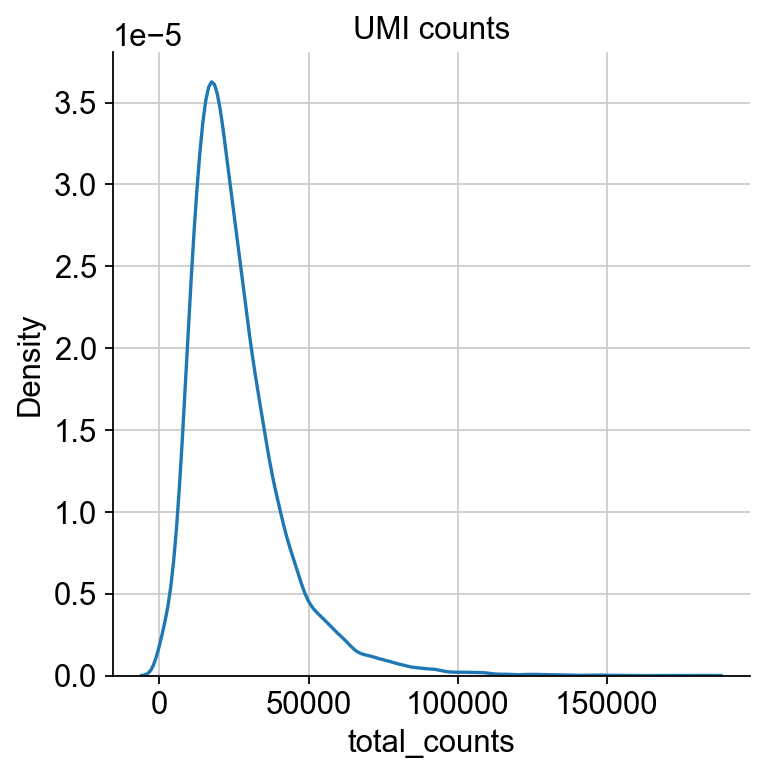

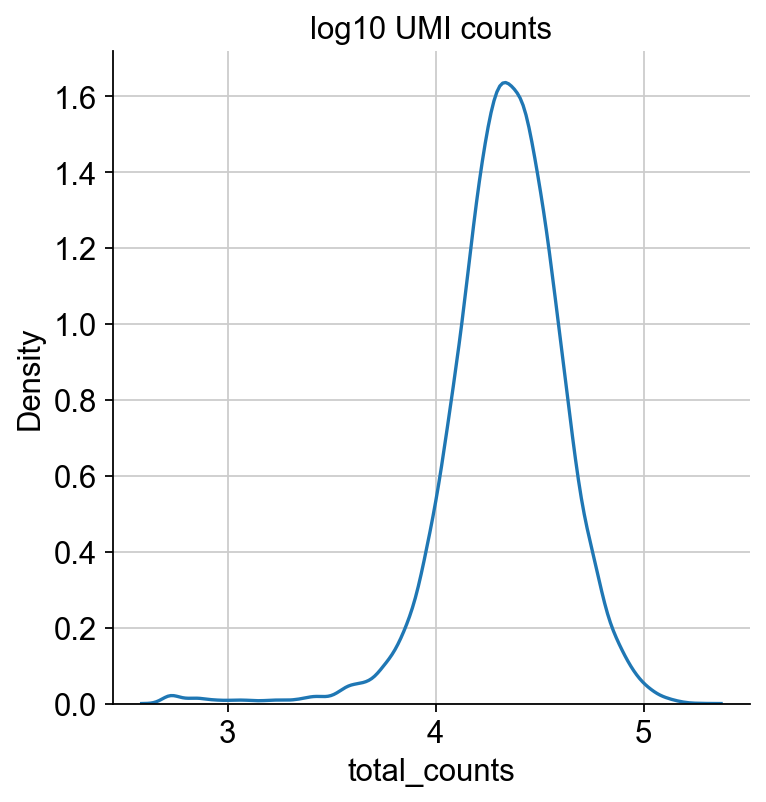

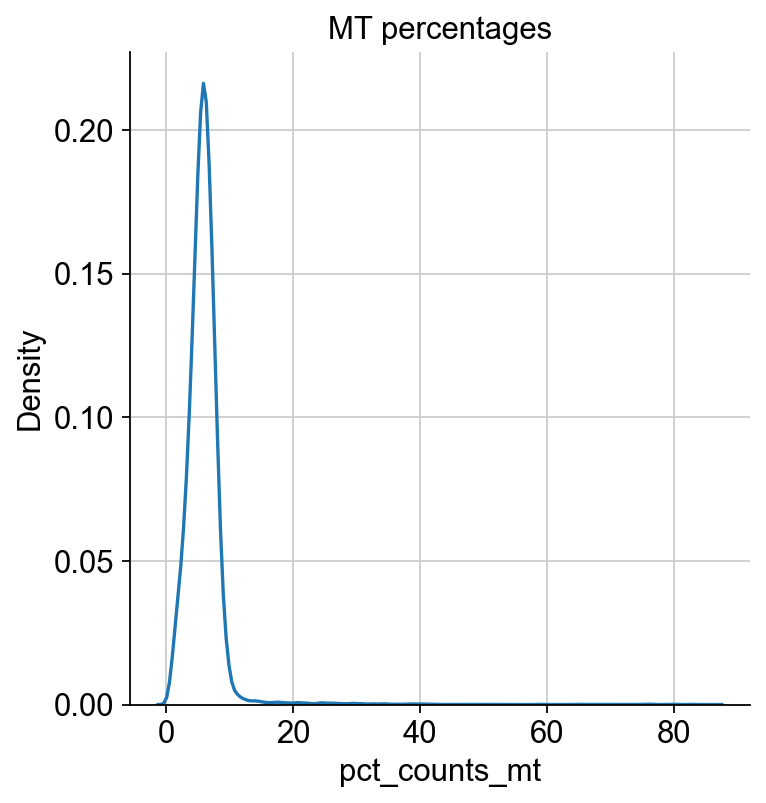

In [8]:
# Output the quality metrics for UMI and MT-gene counts
sns.displot(adata.obs['total_counts'], kind="kde").set(title="UMI counts")
sns.displot(np.log10(adata.obs['total_counts']), kind="kde").set(title="log10 UMI counts")
sns.displot(adata.obs['pct_counts_mt'], kind="kde").set(title="MT percentages")

In [9]:
# Filter out the data based on the values decided from the graph above
adata = adata[adata.obs.total_counts > 5000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.predicted_doublet == False, :]

In [10]:
adata

View of AnnData object with n_obs × n_vars = 20248 × 30267
    obs: 'dataset', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [11]:
# Save the adata
filtered_data_path = out_data_path + "filtered_ad.h5ad"
adata.write_h5ad(filtered_data_path)

/Users/nellia/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
